In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set()

In [54]:
class HIVTreatment:
    def __init__(self, args):
        self.state_names = ("T1", "T1*", "T2", "T2*", "V", "E")
    
        self.continuous_dims = np.arange(6)
        self.actions = np.array([[0., 0.], [.7, 0.], [0., .3], [.7, .3]])
        self.nA = 4
        self.episodeCap = args.episodeCap  #: total of 1000 days with a measurement every 5 days
        self.dt = 5  #: measurement every 5 days
        self.logspace = True  #: whether observed states are in log10 space or not
        #: only update the graphs in showDomain every x steps
        self.show_domain_every = 20
        # store samples of current episode for drawing
        self.episode_data = np.zeros((7, self.episodeCap + 1))

        if self.logspace:
            self.statespace_limits = np.array([[-5, 8]] * 6)
        else:
            self.statespace_limits = np.array([[0., 1e8]] * 6)
        self.state_space_dims = 6
        
        self.action_noise = args.action_noise
        self.action_sigma = args.action_sigma
        self.drop_p = args.drop_p
        
    def step(self, a):
        self.t += 1

        eps1, eps2 = self.actions[a]
        drop = False
        for mini_step in range(self.dt):
            eps1_noisy = max(eps1 + np.random.normal(self.action_noise, self.action_sigma), 0.0)
            eps2_noisy = max(eps2 + np.random.normal(self.action_noise, self.action_sigma), 0.0)
            
            p_drop = self.drop_p * (self.dt + 1 - mini_step)**-1
            if np.random.rand() <= p_drop or drop:
                eps1_noisy = 0
                eps2_noisy = 0
                drop = True
            ns = odeint(dsdt, self.state, [0, 1], #changed [0, dt] to [0, 1]
                    args=(eps1_noisy, eps2_noisy), mxstep=1000)[-1]
            T1, T2, T1s, T2s, V, E = ns
            # the reward function penalizes treatment because of side-effects
            reward = (- 0.1 * V - 2e4 * eps1_noisy ** 2 - 2e3 * eps2_noisy ** 2 + 1e3 * E)/1e5
            self.state = ns.copy()
            if self.logspace:
                ns = np.log10(ns)

        self.episode_data[:-1, self.t] = self.state
        self.episode_data[-1, self.t - 1] = a
        return self.normalizeState(ns), reward, self.isTerminal(), self.possibleActions()
    def normalizeState(self, s):
        return (s - self.statespace_limits[:, 0])/(self.statespace_limits[:, 1] - self.statespace_limits[:, 0])
    def isTerminal(self):
        return self.t >= self.episodeCap
    
    def possibleActions(self):
        return np.arange(4)

    def reset(self):
        self.t = 0
        self.episode_data[:] = np.nan
        # non-healthy stable state of the system
        s = np.array([163573., 5., 11945., 46., 63919., 24.])
        self.state = s.copy()
        self.episode_data[:-1, 0] = s
        if self.logspace:
            s = np.log10(s)
        return self.normalizeState(s)

def dsdt(s, t, eps1, eps2):
    """
    system derivate per time. The unit of time are days.
    """
    # model parameter constants
    lambda1 = 1e4
    lambda2 = 31.98
    d1 = 0.01
    d2 = 0.01
    f = .34
    k1 = 8e-7
    k2 = 1e-4
    delta = .7
    m1 = 1e-5
    m2 = 1e-5
    NT = 100.
    c = 13.
    rho1 = 1.
    rho2 = 1.
    lambdaE = 1
    bE = 0.3
    Kb = 100
    d_E = 0.25
    Kd = 500
    deltaE = 0.1

    # decompose state
    T1, T2, T1s, T2s, V, E = s

    # compute derivatives
    tmp1 = (1. - eps1) * k1 * V * T1
    tmp2 = (1. - f * eps1) * k2 * V * T2
    dT1 = lambda1 - d1 * T1 - tmp1
    dT2 = lambda2 - d2 * T2 - tmp2
    dT1s = tmp1 - delta * T1s - m1 * E * T1s
    dT2s = tmp2 - delta * T2s - m2 * E * T2s
    dV = (1. - eps2) * NT * delta * (T1s + T2s) - c * V \
        - ((1. - eps1) * rho1 * k1 * T1 +
           (1. - f * eps1) * rho2 * k2 * T2) * V
    dE = lambdaE + bE * (T1s + T2s) / (T1s + T2s + Kb) * E \
        - d_E * (T1s + T2s) / (T1s + T2s + Kd) * E - deltaE * E

    return np.array([dT1, dT2, dT1s, dT2s, dV, dE])

### Test Policy

Let's find the optimal policy for a short horizion

In [68]:
args = Namespace(**{'action_noise': 0.2, 'drop_p':0.5, 'action_sigma':0.1,\
                   'episodeCap': 4, 'num_episode': 1000, 'ifCVaR': True, 'opt': 0,\
                   'save_name': 'egreedy', 'alpha': 0.25, 'gamma': 0.99})
env = HIVTreatment(args)

In [69]:
def cv(res, alpha=0.25):
    cvar = np.zeros(res.shape[0])
    var = np.sort(res)[int(len(res) * alpha)]
    idx = np.where(res <= var)
    cvar = np.mean(res[idx])
    return cvar

In [79]:
from itertools import product
ret_cv = []
ret_mean = []
pi = []
for i in product([0, 1, 2, 3], repeat=4): 
    pi.append(list(i))
    s = env.reset()
    ret_pi = []
    for tr in range(100):
        s = env.reset()
        j = 0; t=False
        ret = []
        while not t:
            s, r, t, info = env.step(pi[-1][j])
            ret.append(r)
            j += 1
        ret_pi.append(discounted_return(ret, args.gamma))
    ret_pi = np.array(ret_pi)
    ret_cv.append(cv(ret_pi, args.alpha))
    ret_mean.append(np.mean(ret_pi))

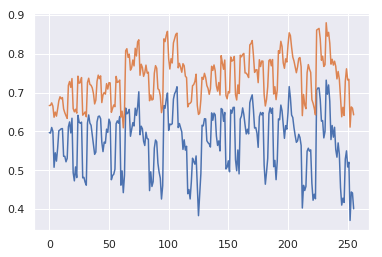

In [80]:
plt.plot(ret_cv)
plt.plot(ret_mean)

0.4180258323275854
0.6700410717383082


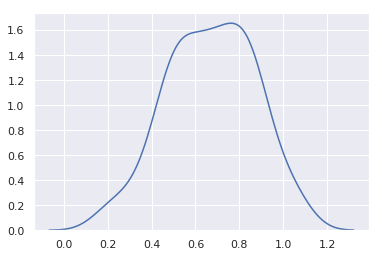

In [74]:
sns.kdeplot(ret_pi)
print(cv(ret_pi, args.alpha))
print(np.mean(ret_pi))

In [81]:
idx = np.argmax(ret_mean)
print(idx)
print(pi[idx][:])
print(np.max(ret_mean))
idx = np.argmax(ret_cv)
print(idx)
print(pi[idx][:])
print(np.max(ret_cv))
print(ret_cv[56])

232
[3, 2, 2, 0]
0.8803554935869758
232
[3, 2, 2, 0]
0.732317314804807
0.6200539787583347


In [18]:
# test to see if it's deterministc

0.46491852080582674


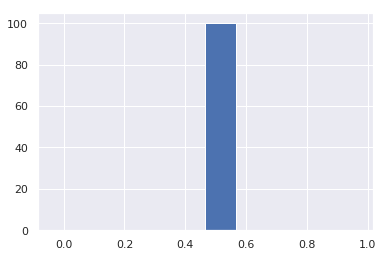

In [9]:
ret_dist = []
pi = [2, 2]
for i in range(100):
    s = env.reset()
    ret = []
    for j in range(2):
        s, r, t, info = env.step(pi[j])
        ret.append(r)
    ret_dist.append(discounted_return(ret, 0.99))
plt.hist(ret_dist)
print(np.mean(ret_dist))

### e-greedy learning of the average

In [3]:
from core import config, drl, replay
import tensorflow as tf
from argparse import Namespace

def discounted_return(returns, gamma):
    ret = 0
    for r in reversed(returns):
        ret = r + gamma * ret
    return ret

/home/ramtin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
args = Namespace(**{'action_noise': 0, 'action_delay':5, 'action_sigma':0,\
                   'episodeCap': 5, 'num_episode': 2000, 'ifCVaR': False, 'opt': 0,\
                   'save_name': 'egreedy', 'alpha': 0.25, 'gamma': 0.99})
tf.reset_default_graph()
with tf.Session() as sess:
    env = HIVTreatment(args)
    Config = config.config(env, args)
    Config.max_step = env.episodeCap
    
    returns = np.zeros((Config.args.num_episode, 2))
    replay_buffer = replay.Replay(Config, load=False)
    counts = np.ones((1, Config.nA))
    C51 = drl.C51(Config, ifCVaR=Config.args.ifCVaR, memory=replay_buffer)
    saver = tf.train.Saver()
    sess.run(tf.initializers.global_variables())
    print("[*] TF model initialized")

    summary_writer = tf.summary.FileWriter(args.save_name + '/summary', sess.graph)
    C51_loss = []
    train_step = 0
    
    for ep in range(Config.args.num_episode):
        terminal = False
        step = 0
        lr = Config.get_lr(ep)
        epsilon = Config.get_epsilon(ep)
 
        episode_return = []
        observation = env.reset()
        pi = []
        while not terminal:
            if np.random.rand() <= epsilon:
                action_id = np.random.randint(Config.nA)
            else:
                if Config.args.ifCVaR:
                    o = np.expand_dims(observation, axis=0)
                    counts = np.ones((1, Config.nA))
                    distribution = C51.predict(sess, o)
                    if ep%Config.print_episode == 0:
                        plt.bar(np.arange(51), distribution[0][0, :])
                        plt.bar(np.arange(51), distribution[1][0, :])
                        plt.bar(np.arange(51), distribution[2][0, :])
                        plt.bar(np.arange(51), distribution[3][0, :])
                        plt.show()
                    values = C51.CVaRopt(distribution, count=counts,\
                                 alpha=Config.args.alpha, N=Config.CVaRSamples, c=args.opt, bonus=0.0)
                    #print(values)
                else:
                    o = np.expand_dims(observation, axis=0)
                    distribution = C51.predict(sess, o)
                    #if ep%Config.print_episode == 0:
                        #plt.bar(np.arange(51), distribution[0][0, :])
                        #plt.bar(np.arange(51), distribution[1][0, :])
                        #plt.bar(np.arange(51), distribution[2][0, :])
                        #plt.bar(np.arange(51), distribution[3][0, :])
                        #plt.show()
                    values = C51.Q(distribution)
                action_id = np.random.choice(np.flatnonzero(values == values.max()))
            next_observation, reward, terminal, info = env.step(action_id)
            pi.append(action_id)
            step += 1
            no = np.expand_dims(next_observation, axis=0)
            next_counts = counts # hack to avoind passing counts
            episode_return.append(reward)
            if step >= Config.max_step:
                terminal = True
                 
            replay_buffer.add(observation, action_id, reward, terminal,\
                                 counts, next_counts)
            # Training:
            l, _ = C51.train(sess=sess, size=Config.train_size, opt=args.opt, learning_rate = lr)
                         
            #if ep%Config.summary_write_episode == 0 and summary is not None:
            #    summary_writer.add_summary(summary, train_step)
            train_step += 1
            if l is not None:
                C51_loss.append(l)
                returns[ep, 1] = l
            observation = next_observation   
        returns[ep, 0] = discounted_return(episode_return, Config.args.gamma)
        if ep%Config.print_episode == 0:
            print("Training.  Episode ep:%3d, Discounted Return = %g, Epsilon = %g, Lr = %g, C51 average loss=%g"\
                         %(ep, returns[ep, 0], epsilon, lr, np.mean(C51_loss)))
        if ep% Config.save_episode == 0:
            save_file = {'ep': ep, 'returns': returns}
            replay_buffer.save(args.save_name)
            pickle_in = open(args.save_name + '.p', 'wb')
            pickle.dump(save_file, pickle_in)
            pickle_in.close()
            saver.save(sess, args.save_name + '.ckpt')

Initialzing the replay buffer
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[*] TF model initialized
Training.  Episode ep:  0, Discounted Return = 1.494, Epsilon = 0.9, Lr = 0.001, C51 average loss=3.78753
Replay buffer saved, name:egreedy.p
Training.  Episode ep:100, Discounted Return = 1.38683, Epsilon = 0.815, Lr = 0.00091, C51 average loss=3.39814
Training.  Episode ep:200, Discounted Return = 0.998597, Epsilon = 0.73, Lr = 0.00082, C51 average loss=3.34929
Training.  Episode ep:300, Discounted Return = 1.16412, Epsilon = 0.645, Lr = 0.00073, C51 average loss=3.32894
Training.  Episode ep:400, Discounted Return = 1.03513, Epsilon = 0.56, Lr = 0.00064, C51 average loss=3.31285
Training.  Episode ep:500, Discounted Return = 1.39163, Epsilon = 0.475, Lr = 0.00055, C51 average loss=3.30316
Training.  Episode ep:600, Discounted Return = 0.944614, Epsilon 

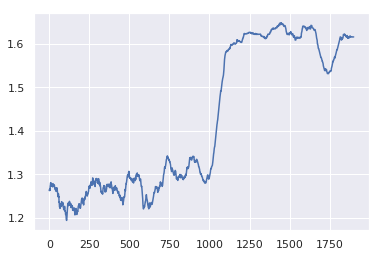

In [41]:
plt.plot(mv(returns[:, 0], 100))

In [10]:
def mv(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

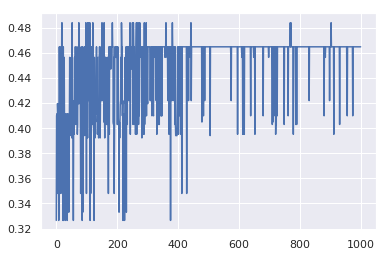

In [8]:
plt.plot(returns[:, 0])

In [26]:
Config.args.gamma

0.99